# Setup

In [62]:
# @markdown #### Caso escolheu o tipo de recuperação drive/ambos e não tenha os arquivos, faça um atalho desse drive:
link_do_drive = "https://drive.google.com/drive/folders/1YZi_e0NhsvOW0hL5-5Y-jfUlTc-NHM3f?usp=drive_link" #@param {type:"string"}
path_atalho_drive = "/content/drive/MyDrive/Projetos Do GitHub/python_classification_som_wine" #@param {type:"string"}
path_download = "python_classification_som_wine" #@param {type:"string"}

In [63]:
import os
import zipfile

if os.path.exists('python_download_file_drive'):
  !cd python_download_file_drive && git pull
else:
  !git clone https://github.com/KauaHenSilva/python_download_file_drive
%pip install --upgrade --quiet -r python_download_file_drive/requirements.txt

Already up to date.


In [64]:
try:
    from google.colab import drive
    from google.colab import auth
    from googleapiclient.discovery import build
    auth.authenticate_user()

    !python "python_download_file_drive/main.py" {link_do_drive} {path_download} # ALERTA: Caso o drive bote limite de download comente essa linha

    drive.mount('/content/drive')
    if not os.path.exists(path_atalho_drive):
      print("[INFO] Atalho no drive não encontrado.")

except:

    if os.path.exists(f"{path_download}.zip"):
      print(f"Descompactando {path_download}.zip")
      !rm -rf {path_download}
      with zipfile.ZipFile(f"{path_download}.zip", 'r') as zip_ref:
        zip_ref.extractall(f"{path_download}_temp")
        !mv {path_download}_temp/* {path_download}
        !rm -rf {path_download}_temp
        !rm -rf {path_download}.zip

    if not os.path.exists(path_download):
      raise Exception(f"Você não está nos altenticado nos servidores do google colab. Para prosseguir, faça o download dos arquivos que estão presente no drive e tente novamente. O link do drive {link_do_drive}. A pasta deve está dentro de /content/")


In [65]:
def get_referencia_valida(path, path_atalho_drive, file_init):
    path_download = os.path.join(file_init, path)
    path_drive = os.path.join(path_atalho_drive, path)

    bool_download = os.path.exists(path_download)
    bool_drive = os.path.exists(path_drive)

    if not bool_download and not bool_drive:
        raise Exception(f"Arquivo não encontrado em nenhum dos caminhos (Download ou Drive). Caminhos: {path_download}, {path_drive}")

    if not bool_drive and bool_download:
        print("[INFO] Arquivo encontrado no download, mas não no drive.")
        return path_download

    if bool_drive and not bool_download:
        print("[INFO] Arquivo encontrado no drive, mas não no download.")
        return path_drive

    return path_download


# Imports

In [66]:
%pip install minisom

In [67]:
import minisom
import pandas as pd
import sklearn
import matplotlib

In [68]:
pd.__version__, sklearn.__version__, matplotlib.__version__

('2.2.2', '1.6.0', '3.8.0')

In [69]:
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pylab import pcolor, colorbar, plot

# Database

In [70]:
path_base = get_referencia_valida("wines.csv", path_atalho_drive, path_download)

[INFO] Arquivo encontrado no download, mas não no drive.


In [71]:
base = pd.read_csv(path_base)
base.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [72]:
base.describe()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [73]:
base.isnull().sum()

,0
Class,0
Alcohol,0
Malic acid,0
Ash,0
Alcalinity of ash,0
Magnesium,0
Total phenols,0
Flavanoids,0
Nonflavanoid phenols,0
Proanthocyanins,0


In [74]:
base.shape

(178, 14)

# Preprocessing

In [75]:
X = base.iloc[:, 1:14].values
y = base.iloc[:, 0].values

In [76]:
X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)

In [77]:
X, y

(array([[0.84210526, 0.1916996 , 0.57219251, ..., 0.45528455, 0.97069597,
         0.56134094],
        [0.57105263, 0.2055336 , 0.4171123 , ..., 0.46341463, 0.78021978,
         0.55064194],
        [0.56052632, 0.3201581 , 0.70053476, ..., 0.44715447, 0.6959707 ,
         0.64693295],
        ...,
        [0.58947368, 0.69960474, 0.48128342, ..., 0.08943089, 0.10622711,
         0.39728959],
        [0.56315789, 0.36561265, 0.54010695, ..., 0.09756098, 0.12820513,
         0.40085592],
        [0.81578947, 0.66403162, 0.73796791, ..., 0.10569106, 0.12087912,
         0.20114123]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

# Training

In [78]:
som = MiniSom(x = 8, y = 8, input_len=13, sigma=1.0, learning_rate=0.5, random_seed=2)
som.random_weights_init(X)

In [79]:
som.train_random(data=X, num_iteration=600, verbose=True)

 [ 600 / 600 ] 100% - 0:00:00 left 
 quantization error: 0.292309454194876


# Results

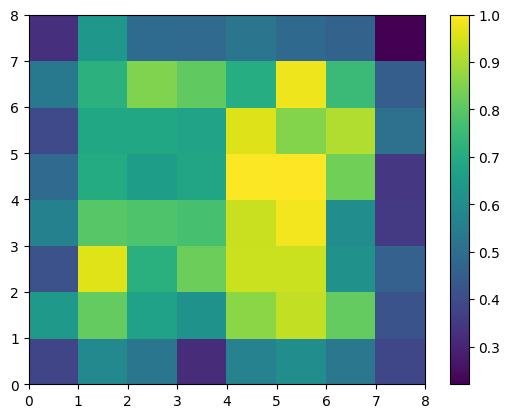

In [80]:
pcolor(som.distance_map().T)
colorbar();

In [81]:
w1,w2 = som.winner(X[0]), som.winner(X[1])
w1, w2

((6, 2), (5, 2))

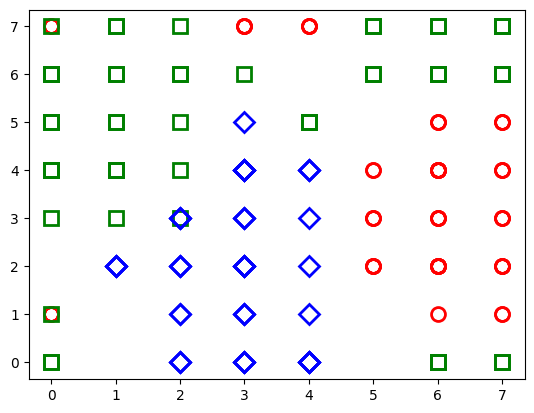

In [82]:
markers = ['o', 's', 'D']
color = ['r', 'g', 'b']

for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0], w[1], markers[y[i] - 1], markerfacecolor='None', markersize=10, markeredgecolor=color[y[i] - 1], markeredgewidth=2)